In [1]:
import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=100 # highres display

# for nice inset colorbars:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def apply_layer(y_in,w,b,activation):
    """
    Go from one layer to the next, given a 
    weight matrix w (shape [n_neurons_in,n_neurons_out])
    a bias vector b (length n_neurons_out)
    and the values of input neurons y_in 
    (shape [batchsize,n_neurons_in])
    
    returns the values of the output neurons in the next layer 
    (shape [batchsize, n_neurons_out])
    """
    # to understand the following line, watch the beginning of lecture 2
    z=np.dot(y_in,w)+b # batch processing: y_in is of shape [batchsize,num_neurons_in]
    if activation=='sigmoid':
        return(1/(1+np.exp(-z)))
    elif activation=='jump':
        return(np.array(z>0,dtype='float'))
    elif activation=='linear':
        return(z)
    elif activation=='reLU':
        return((z>0)*z)

def apply_net(y_in,weights,biases,activations):
    """
    Apply a whole network of multiple layers
    """
    y=y_in
    for j in range(len(biases)):
        y=apply_layer(y,weights[j],biases[j],activations[j])
    return(y)

# some internal routines for plotting the network:
def plot_connection_line(ax,X,Y,W,vmax=1.0,linewidth=3):
    t=np.linspace(0,1,20)
    if W>0:
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.plot(X[0]+(3*t**2-2*t**3)*(X[1]-X[0]),Y[0]+t*(Y[1]-Y[0]),
           alpha=abs(W)/vmax,color=col,
           linewidth=linewidth)
    
def plot_neuron_alpha(ax,X,Y,B,size=100.0,vmax=1.0):
    if B>0:
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.scatter([X],[Y],marker='o',c=col,alpha=abs(B)/vmax,s=size,zorder=10)

def plot_neuron(ax,X,Y,B,size=100.0,vmax=1.0):
    if B>0:
        col=[0,0.4,0.8]
    else:
        col=[1,0.3,0]
    ax.scatter([X],[Y],marker='o',c=col,s=size,zorder=10)
    
def visualize_network(weights,biases,activations,
                      M=100,y0range=[-1,1],y1range=[-1,1],
                     size=400.0, linewidth=5.0):
    """
    Visualize a neural network with 2 input 
    neurons and 1 output neuron (plot output vs input in a 2D plot)
    
    weights is a list of the weight matrices for the
    layers, where weights[j] is the matrix for the connections
    from layer j to layer j+1 (where j==0 is the input)
    
    weights[j][m,k] is the weight for input neuron k going to output neuron m
    (note: internally, m and k are swapped, see the explanation of
    batch processing in lecture 2)
    
    biases[j] is the vector of bias values for obtaining the neurons in layer j+1
    biases[j][k] is the bias for neuron k in layer j+1
    
    activations is a list of the activation functions for
    the different layers: choose 'linear','sigmoid',
    'jump' (i.e. step-function), and 'reLU'
    
    M is the resolution (MxM grid)
    
    y0range is the range of y0 neuron values (horizontal axis)
    y1range is the range of y1 neuron values (vertical axis)
    """
    swapped_weights=[]
    for j in range(len(weights)):
        swapped_weights.append(np.transpose(weights[j]))
        
    y0,y1=np.meshgrid(np.linspace(y0range[0],y0range[1],M),np.linspace(y1range[0],y1range[1],M))
    y_in=np.zeros([M*M,2])
    y_in[:,0]=y0.flatten()
    y_in[:,1]=y1.flatten()
    y_out=apply_net(y_in,swapped_weights,biases,activations)

    fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(4,4))
    
    # plot the network itself:
    
    # positions of neurons on plot:
    posX=[[-0.5,+0.5]]; posY=[[0,0]]
    vmax=0.0 # for finding the maximum weight
    vmaxB=0.0 # for maximum bias
    for j in range(len(biases)):
        n_neurons=len(biases[j])
        posX.append(np.array(range(n_neurons))-0.5*(n_neurons-1))
        posY.append(np.full(n_neurons,j+1))
        vmax=np.maximum(vmax,np.max(np.abs(weights[j])))
        vmaxB=np.maximum(vmaxB,np.max(np.abs(biases[j])))

    # plot connections
    for j in range(len(biases)):
        for k in range(len(posX[j])):
            for m in range(len(posX[j+1])):
                plot_connection_line(ax,[posX[j][k],posX[j+1][m]],
                                     [posY[j][k],posY[j+1][m]],
                                     swapped_weights[j][k,m],vmax=vmax,
                                    linewidth=linewidth)
    
    # plot neurons
    for k in range(len(posX[0])): # input neurons (have no bias!)
        plot_neuron(ax,posX[0][k],posY[0][k],
                   vmaxB,vmax=vmaxB,size=size)
    for j in range(len(biases)): # all other neurons
        for k in range(len(posX[j+1])):
            plot_neuron(ax,posX[j+1][k],posY[j+1][k],
                       biases[j][k],vmax=vmaxB,size=size)
    
    ax.axis('off')
    
    # now: the output of the network
#     img=ax[1].imshow(np.reshape(y_out,[M,M]),origin='lower',
#                     extent=[y0range[0],y0range[1],y1range[0],y1range[1]])
#     ax[1].set_xlabel(r'$y_0$')
#     ax[1].set_ylabel(r'$y_1$')
    
#     axins1 = inset_axes(ax[1],
#                     width="40%",  # width = 50% of parent_bbox width
#                     height="5%",  # height : 5%
#                     loc='upper right')

#     imgmin=np.min(y_out)
#     imgmax=np.max(y_out)
#     color_bar=fig.colorbar(img, cax=axins1, orientation="horizontal",ticks=np.linspace(imgmin,imgmax,3))
#     cbxtick_obj = plt.getp(color_bar.ax.axes, 'xticklabels')
#     plt.setp(cbxtick_obj, color="white")
#     axins1.xaxis.set_ticks_position("bottom")

    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


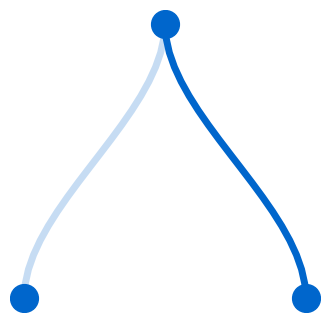

In [3]:
visualize_network(weights=[ [ 
    [0.2,0.9]  # weights of 2 input neurons for single output neuron
    ] ],
    biases=[ 
        [0.5] # bias for single output neuron
            ],
    activations=[ 'sigmoid' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

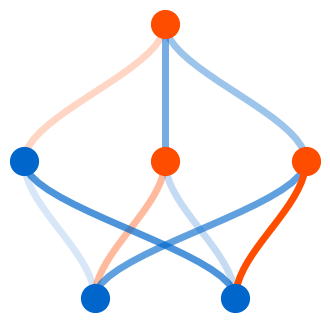

In [4]:
visualize_network(weights=[ [ 
    [0.2,0.9],  # weights of 2 input neurons for 1st hidden neuron
    [-0.5,0.3], # weights of 2 input neurons for 2nd hidden
    [0.8,-1.3]  # weights of 2 input neurons for 3rd hidden
    ],                 
    [ 
        [-0.3,0.7,0.5] # weights of 3 hidden neurons for output
    ]  ],
    biases=[ 
        [0.1,-0.5,-0.5], # biases of 3 hidden neurons
        [-.2] # bias for output neuron
            ],
    activations=[ 'jump', # activation for hidden
                'jump' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

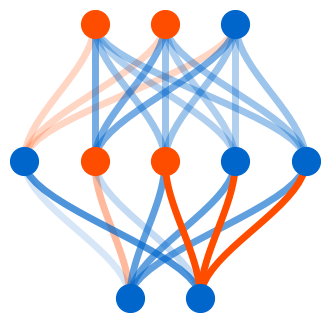

In [5]:
visualize_network(weights=[ [ 
    [0.2,0.9],  # weights of 2 input neurons for 1st hidden neuron
    [-0.5,0.3], # weights of 2 input neurons for 2nd hidden
    [0.8,-1.3],
      [0.8,-1.3],
    [0.8,-1.3]# weights of 2 input neurons for 3rd hidden
    ],                 
    [ 
        [-0.3,0.7,0.5, 0.4, 0.5] # weights of 3 hidden neurons for output
    ,[-0.3,0.7,0.5, 0.4, 0.5]
         ,[-0.3,0.7,0.5, 0.4, 0.5]
    ]  ],
    biases=[ 
        [0.1,-0.5,-0.5, 0.4, 0.5], # biases of 3 hidden neurons
        [-.2, -0.2, 0.2] # bias for output neuron
            ],
    activations=[ 'jump', # activation for hidden
                'jump' # activation for output
                ],
    y0range=[-3,3],y1range=[-3,3])

In [6]:
import pandas as pd
df_0 = pd.read_csv('RawData/two_widths/Param0_2width.csv')
df_1 = pd.read_csv('RawData/two_widths/Param1_2width.csv')
df_2 = pd.read_csv('RawData/two_widths/Param2_2width.csv')
df_3 = pd.read_csv('RawData/two_widths/Param3_2width.csv')
df_4 = pd.read_csv('RawData/two_widths/Param4_2width.csv')

dataset = pd.concat([df_0, df_1, df_2, df_3, df_4], axis = 0, ignore_index = True)
dataset.keys()

Index(['Frequency', 'Speed', 'Amplitude', 'Passes', 'Focal_Position', 'Depth',
       'Top_width', 'Bot_width'],
      dtype='object')

In [10]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
# load pima indians dataset
# dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset.iloc[:,1:5]
Y = dataset.iloc[:,5:8]
# create model
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='relu'))
# Compile model
model.compile(optimizer='adam', loss='mse')
# Fit the model
model.fit(X, Y, epochs=1000, batch_size=64 ,verbose=0)
# evaluate the model
# pred = model.predict(X)
#     error = (mean_squared_error(pred, Y_test)).round(3)
#     Rsquare = (r2_score(pred, Y_test)).round(3)
#     return error , Rsquare
# scores = model.evaluate(X, Y)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [11]:
from ann_visualizer.visualize import ann_viz;

ann_viz(model, title="My first neural network")

ModuleNotFoundError: No module named 'ann_visualizer'

In [39]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_sizes[n]):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

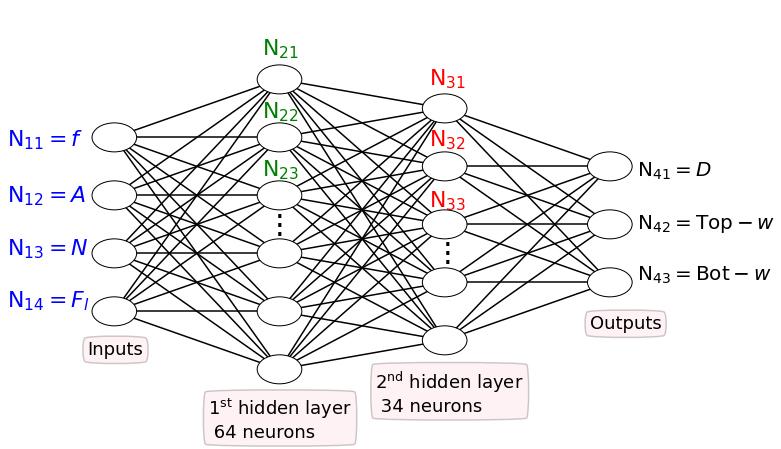

In [241]:
fig = plt.figure(figsize=(12, 8))
bbox_propsLAD = dict(boxstyle="round4,pad=0.3", fc="pink", ec="k", lw=1.5, alpha=0.2)


ax = fig.gca()
ax.axis('off')
ax.annotate('N$_{11}=f$', xy = [0,0.68], color= 'b', fontsize=22)
ax.annotate('N$_{12}=A$', xy = [0,0.55],c='b', fontsize=22)
ax.annotate('N$_{13}=N$', xy = [0,0.43],c='b', fontsize=22)
ax.annotate('N$_{14}=F_l$', xy = [0,0.31],c='b', fontsize=22)

ax.annotate('N$_{21}$', xy = [0.38,0.89],c='g', fontsize=22)
ax.annotate('N$_{22}$', xy = [0.38,0.745],c='g', fontsize=22)
ax.annotate('N$_{23}$', xy = [0.38,0.61], c='g',fontsize=22)

ax.annotate('.', xy = [0.4,0.515],c='k', fontsize=30)
ax.annotate('.', xy = [0.4,0.495],c='k', fontsize=30)
ax.annotate('.', xy = [0.4,0.475],c='k', fontsize=30)

ax.annotate('N$_{31}$', xy = [0.63,0.82],c='r', fontsize=22)
ax.annotate('N$_{32}$', xy = [0.63,0.68],c='r', fontsize=22)
ax.annotate('N$_{33}$', xy = [0.63,0.54],c='r', fontsize=22)

ax.annotate('.', xy = [0.65,0.45],c='k', fontsize=30)
ax.annotate('.', xy = [0.65,0.43],c='k', fontsize=30)
ax.annotate('.', xy = [0.65,0.41],c='k', fontsize=30)



ax.annotate('N$_{41}=D$', xy = [0.94,0.61], fontsize=20)
ax.annotate('N$_{42}=\mathrm{Top}-w$', xy = [0.94,0.49], fontsize=20)
ax.annotate('N$_{43}=\mathrm{Bot}-w$', xy = [0.94,0.37], fontsize=20)



ax.annotate('Inputs', xy = [0.12,0.2], fontsize=18,bbox=bbox_propsLAD)
ax.annotate('1$^{\mathrm{st}}$ hidden layer \n 64 neurons', xy = [0.3,0.01],
            fontsize=18,bbox=bbox_propsLAD)
ax.annotate('2$^{\mathrm{nd}}$ hidden layer \n 34 neurons', xy = [0.55,0.07],
            fontsize=18,bbox=bbox_propsLAD)

ax.annotate('Outputs', xy = [0.87,0.26], fontsize=18,bbox=bbox_propsLAD)


draw_neural_net(ax, .16, 0.9, .1, .9, [4, 6, 5 ,3])

fig.savefig('nn.png',bbox_inches='tight')

In [56]:
# !sudo pip3 install ann_visualizer

Password:
sudo: a password is required
